In [13]:
import duckdb

con = duckdb.connect("../db/synpuf.duckdb")

# Only select necessary columns to reduce memory usage
query = """
SELECT 
    b.DESYNPUF_ID,
    b.BENE_BIRTH_DT,
    b.BENE_SEX_IDENT_CD,
    COUNT(DISTINCT i.CLM_ID) AS inpatient_claim_count,
    SUM(i.CLM_PMT_AMT) AS inpatient_total_paid
FROM beneficiary_all b
LEFT JOIN inpatient i ON b.DESYNPUF_ID = i.DESYNPUF_ID
GROUP BY b.DESYNPUF_ID, b.BENE_BIRTH_DT, b.BENE_SEX_IDENT_CD
"""
df_features = con.execute(query).fetchdf()  # Only a subset of rows if needed


In [15]:
BATCH_SIZE = 100_000
total_bene = con.execute("SELECT COUNT(*) FROM beneficiary_all").fetchone()[0]
n_batches = (total_bene // BATCH_SIZE) + 1

for batch in range(n_batches):
    query = f"""
    SELECT b.DESYNPUF_ID, COUNT(DISTINCT i.CLM_ID) AS ip_claim_count
    FROM (SELECT * FROM beneficiary_all LIMIT {BATCH_SIZE} OFFSET {batch*BATCH_SIZE}) b
    LEFT JOIN inpatient i ON b.DESYNPUF_ID = i.DESYNPUF_ID
    GROUP BY b.DESYNPUF_ID
    """
    features_path = "/media/jeyanth-s/DevDrive/AI_Workspace/projects/Cognitives---Member-Risk-Stratification-and-Care-Management/pipeline/features"
    df_batch = con.execute(query).fetchdf()
    df_batch.to_parquet(f"{features_path}/ml_batch_{batch}.parquet", engine='pyarrow')


343644


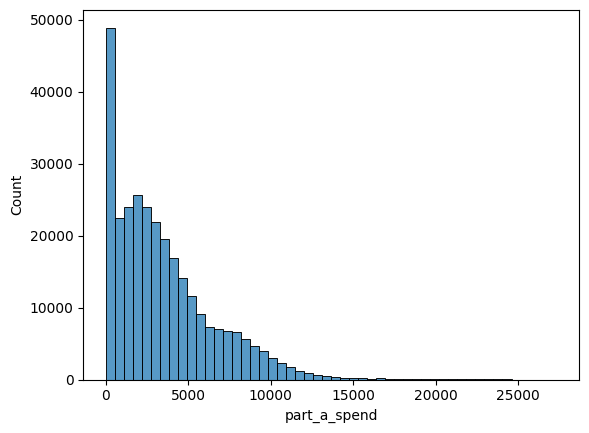

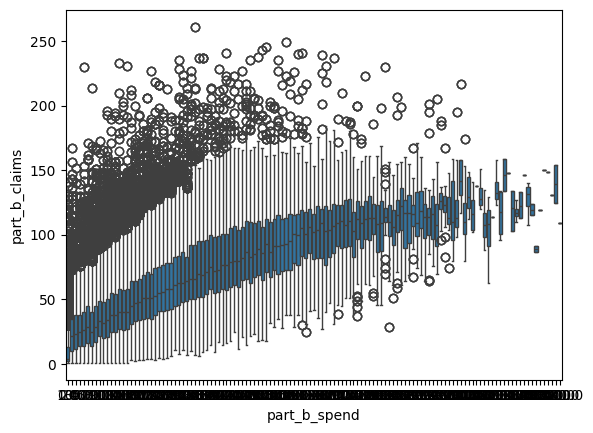

In [11]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

# Load ML features (lightweight)
df = pl.read_parquet(features_path+"/ml_features.parquet").to_pandas()
print(len(df))
# Example visualizations
sns.histplot(df['part_a_spend'], bins=50)
plt.show()

sns.boxplot(x=df['part_b_spend'], y=df['part_b_claims'])
plt.show()


In [16]:
df.columns

Index(['DESYNPUF_ID', 'BENE_BIRTH_DT', 'BENE_SEX_IDENT_CD', 'BENE_RACE_CD',
       'part_a_claims', 'part_a_spend', 'part_b_claims', 'part_b_spend'],
      dtype='object')